              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2839
           1       0.93      0.80      0.86      1108

    accuracy                           0.93      3947
   macro avg       0.93      0.89      0.91      3947
weighted avg       0.93      0.93      0.93      3947

Precision: 0.9261610424323421
Recall: 0.9764001408946812
F1 Score: 0.9506172839506172


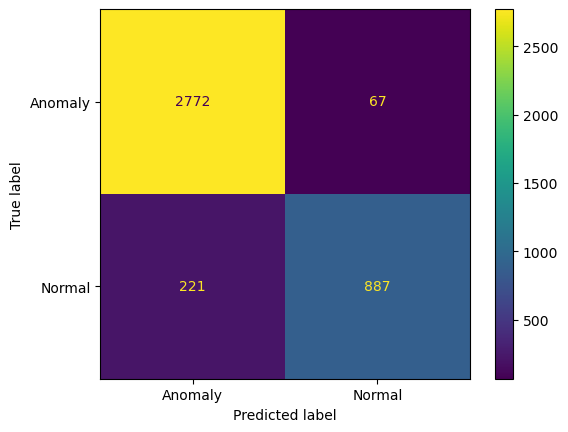

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix

def hybrid_anomaly_detection():
    
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 5, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    
    
    
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Phase 1: Train Isolation Forest on the training data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train)
    # Predict on the training data to filter for normal data only
    train_preds = iso_forest.predict(X_train)

    # Filter normal data as input for the SVM
    X_train_filtered = X_train[train_preds == 1]
    y_train_filtered = y_train[train_preds == 1]

    # Phase 2: Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_filtered, y_train_filtered)

    # Evaluate on the original full test dataset
    svm_predictions = svm.predict(X_test)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, svm_predictions, pos_label=0)
    recall = recall_score(y_test, svm_predictions, pos_label=0)
    f1 = f1_score(y_test, svm_predictions, pos_label=0)

    # Print metrics
    
    print(classification_report(y_test, svm_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Assuming X and y are your dataset's features and labels respectively
hybrid_anomaly_detection()
